## The functionalities in this notebook is as follows:

1. Start witha kernel that has only positive coefficients

2. sample a GP from this kernel 

3. fit a GP with arbitrary taylor expansion (of fixed term)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
import gpflow
import tensorflow as tf
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx

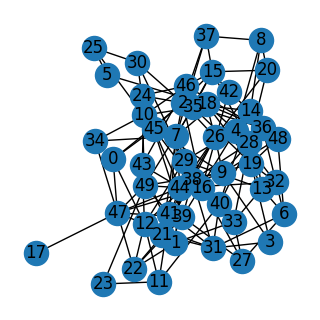

In [12]:
# Sample a Graph
# Parameters
num_nodes = 50
# Generate an undirected random graph
probability = 0.1  # Probability of edge creation
G = nx.erdos_renyi_graph(num_nodes, probability, directed=False)  # Ensure the graph is undirected
adjacency_matrix = nx.to_numpy_array(G)  # Convert to adjacency matrix

#plot the sampled graph G
nx.draw(G, with_labels=True)
plt.show()

## Helper Functions

In [13]:
def get_laplacian_matrix(A):
    """
    Computes the normalized Laplacian matrix from the adjacency matrix.
    
    Parameters:
        A (np.ndarray): Adjacency matrix of the graph.
        
    Returns:
        L (np.ndarray): Normalized Laplacian matrix.
    """
    # Degree matrix D
    degrees = np.sum(A, axis=1)
    D = np.diag(degrees)
    
    # Compute D^{-1/2}
    with np.errstate(divide='ignore'):
        D_inv_sqrt = np.diag(1.0 / np.sqrt(degrees))
    
    # Replace infinities with zeros (in case of isolated nodes)
    D_inv_sqrt[np.isinf(D_inv_sqrt)] = 0
    
    # Compute the normalized Laplacian
    I = np.eye(len(A))
    L = I - D_inv_sqrt @ A @ D_inv_sqrt
    
    return L

def compute_kernel(L):
    """
    Computes the kernel matrix K = I + L + L^2 + L^3.
    
    Parameters:
        L (np.ndarray): Normalized Laplacian matrix.
        
    Returns:
        K (np.ndarray): Kernel matrix.
    """
    # Identity matrix
    I = np.eye(len(L))
    
    # Compute powers of L
    L2 = L @ L
    L3 = L2 @ L
    
    # Compute the kernel K
    K = I + L + L2 + L3
    
    return K


## Sampling

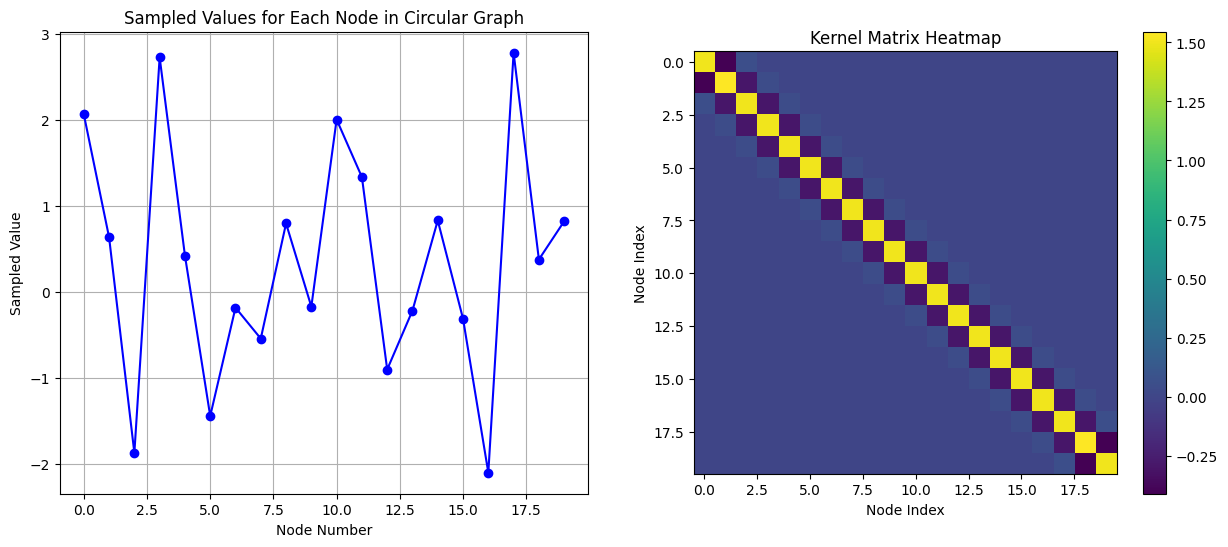

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def compute_kernel(adj_matrix, alpha=0.1):
    # Compute degrees and normalized Laplacian
    degrees = adj_matrix.sum(axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(degrees))
    D_inv_sqrt[np.isinf(D_inv_sqrt)] = 0  # Handle division by zero for isolated nodes
    L = np.eye(len(adj_matrix)) - D_inv_sqrt @ adj_matrix @ D_inv_sqrt

    # Compute kernel K = I + L + L^2 + L^3
    L_power = L.copy()
    K = np.eye(len(adj_matrix))
    L_power = np.eye(len(adj_matrix))
    for k in range(1, 4):
        L_power = L_power @ L
        K += alpha**k * L_power
    return K

def plot_sampled_values(alpha=0.3):
    num_nodes = 20
    adjacency_matrix = np.eye(num_nodes, k=1) + np.eye(num_nodes, k=-1)  # Circular adjacency matrix

    K = compute_kernel(adjacency_matrix,alpha)
    L_chol = np.linalg.cholesky(K + 1e-6 * np.eye(num_nodes))  # Cholesky decomposition
    samples = L_chol @ np.random.randn(num_nodes, 1)  # Sample from Gaussian process

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Plot sampled values
    axs[0].plot(samples, marker='o', linestyle='-', color='b')
    axs[0].set_title('Sampled Values for Each Node in Circular Graph')
    axs[0].set_xlabel('Node Number')
    axs[0].set_ylabel('Sampled Value')
    axs[0].grid()

    # Plot kernel matrix as a heatmap
    cax = axs[1].imshow(K, cmap='viridis')
    axs[1].set_title('Kernel Matrix Heatmap')
    plt.colorbar(cax, ax=axs[1])
    axs[1].set_xlabel('Node Index')
    axs[1].set_ylabel('Node Index')

    plt.show()

plot_sampled_values()


## My Kernel

In [25]:
import gpflow
import tensorflow as tf

class GraphKernel(gpflow.kernels.Kernel):
    def __init__(self, laplacian, **kwargs):
        super().__init__(**kwargs)
        self.num_nodes = laplacian.shape[0]
        self.L = tf.convert_to_tensor(laplacian, dtype=tf.float64)
        self.I = tf.eye(self.num_nodes, dtype=tf.float64)

        # Learnable parameters a1, a2, a3 (positive constraints)
        self.a1 = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
        self.a2 = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
        self.a3 = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())

        # Precompute L^2 and L^3
        self.L2 = tf.matmul(self.L, self.L)
        self.L3 = tf.matmul(self.L2, self.L)

    def K(self, X, X2=None):
        indices_X = tf.cast(tf.squeeze(X), tf.int32)
        indices_X2 = tf.cast(tf.squeeze(X2), tf.int32) if X2 is not None else indices_X

        # Compute full kernel matrix
        K_full = self.I + self.a1 * self.L + self.a2 * self.L2 + self.a3 * self.L3

        # Extract submatrix corresponding to inputs
        K_sub = tf.gather(tf.gather(K_full, indices_X, axis=0), indices_X2, axis=1)
        return K_sub

    def K_diag(self, X):
        indices_X = tf.cast(tf.squeeze(X), tf.int32)
        K_diag_full = tf.linalg.diag_part(self.I + self.a1 * self.L + self.a2 * self.L2 + self.a3 * self.L3)
        K_diag = tf.gather(K_diag_full, indices_X)
        return K_diag


## Example

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown
import networkx as nx

# Function to compute the normalized Laplacian
def compute_normalized_laplacian(adj_matrix):
    degrees = adj_matrix.sum(axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(degrees))
    D_inv_sqrt[np.isinf(D_inv_sqrt)] = 0  # Handle division by zero
    L = np.eye(len(adj_matrix)) - D_inv_sqrt @ adj_matrix @ D_inv_sqrt
    return L

# Function to compute the kernel series K = I + alpha L + alpha^2 L^2 + ... up to num_terms
def compute_kernel_series(L, alpha, num_terms=20):
    K = np.eye(len(L))
    L_power = np.eye(len(L))
    for k in range(1, num_terms + 1):
        L_power = L_power @ L
        K += alpha**k * L_power
    return K

# Custom Graph Kernel with learnable parameters a1, a2, a3
class GraphKernel(gpflow.kernels.Kernel):
    def __init__(self, laplacian, **kwargs):
        super().__init__(**kwargs)
        self.L = tf.convert_to_tensor(laplacian, dtype=tf.float64)
        self.I = tf.eye(self.L.shape[0], dtype=tf.float64)
        self.a1 = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
        self.a2 = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
        self.a3 = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
        self.L2 = tf.matmul(self.L, self.L)
        self.L3 = tf.matmul(self.L2, self.L)

    def K(self, X, X2=None):
        indices_X = tf.cast(tf.squeeze(X), tf.int32)
        indices_X2 = tf.cast(tf.squeeze(X2), tf.int32) if X2 is not None else indices_X
        K_full = self.I + self.a1 * self.L + self.a2 * self.L2 + self.a3 * self.L3
        K_sub = tf.gather(tf.gather(K_full, indices_X, axis=0), indices_X2, axis=1)
        return K_sub

    def K_diag(self, X):
        indices_X = tf.cast(tf.squeeze(X), tf.int32)
        K_diag_full = tf.linalg.diag_part(self.I + self.a1 * self.L + self.a2 * self.L2 + self.a3 * self.L3)
        K_diag = tf.gather(K_diag_full, indices_X)
        return K_diag

# Parameters
num_nodes = 50
adjacency_matrix = np.eye(num_nodes, k=1) + np.eye(num_nodes, k=-1)  # Circular adjacency matrix
L = compute_normalized_laplacian(adjacency_matrix)

# Function to generate noisy samples
def generate_noisy_samples(alpha_sample, noise_level):
    K_sample = compute_kernel_series(L, alpha_sample, num_terms=20)
    L_chol = np.linalg.cholesky(K_sample + 1e-6 * np.eye(num_nodes))
    true_samples = L_chol @ np.random.normal(size=(num_nodes, 1))
    noise = noise_level * np.random.randn(num_nodes, 1)
    Y_noisy = true_samples + noise
    return Y_noisy

# Function to plot results
def plot_results(alpha_sample, noise_level):
    clear_output(wait=True)
    Y_noisy = generate_noisy_samples(alpha_sample, noise_level)
    X = tf.convert_to_tensor(np.arange(num_nodes).reshape(-1, 1), dtype=tf.float64)
    Y = tf.convert_to_tensor(Y_noisy, dtype=tf.float64)

    # Create the GP model with the custom kernel
    graph_kernel = GraphKernel(L)
    model = gpflow.models.GPR(data=(X, Y), kernel=graph_kernel)
    gpflow.optimizers.Scipy().minimize(model.training_loss, model.trainable_variables)

    # Predictions
    mean, variance = model.predict_f(X)
    stddev = tf.sqrt(variance)

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].plot(X.numpy(), Y.numpy(), 'ro', label='Noisy Samples')
    ax[0].plot(X.numpy(), mean.numpy(), 'b-', label='Fitted Mean')
    ax[0].fill_between(X.numpy().flatten(),
                       (mean - 1.96 * stddev).numpy().flatten(),
                       (mean + 1.96 * stddev).numpy().flatten(),
                       color='lightblue', alpha=0.5, label='95% Confidence Interval')
    ax[0].set_title(f'Gaussian Process Fit with Custom Graph Kernel')
    ax[0].set_xlabel('Node Number')
    ax[0].set_ylabel('Sampled Value')
    ax[0].grid()
    ax[0].legend()

    # Plot the network graph
    G = nx.from_numpy_array(adjacency_matrix)
    pos = nx.circular_layout(G)
    nx.draw(G, pos, ax=ax[1], with_labels=False, node_color='skyblue', edge_color='gray', node_size=50)
    ax[1].set_title("Network Graph Representation")
    ax[1].axis("off")

    plt.show()

    # Output the true kernel expression
    display(Markdown(f"**True Kernel Expression:**"))
    display(Markdown(f"$$K = I + \\alpha L + \\alpha^2 L^2 + \\alpha^3 L^3 + \\cdots \\text{{ up to }} n_{{\\text{{terms}}}} = 20$$"))
    display(Markdown(f"Where \\( \\alpha = {alpha_sample:.4f} \\)"))

    # Output the noise level
    display(Markdown(f"**Noise Level (Standard Deviation):** {noise_level:.4f}"))

    # Output the fitted kernel expression
    display(Markdown(f"**Fitted Kernel Expression:**"))
    display(Markdown(f"$$K = I + a_1 L + a_2 L^2 + a_3 L^3$$"))

    # Output the fitted parameters
    a1_val = model.kernel.a1.numpy()
    a2_val = model.kernel.a2.numpy()
    a3_val = model.kernel.a3.numpy()
    display(Markdown(f"**Learned Parameters:**"))
    display(Markdown(f"\\( a_1 = {a1_val:.4f} \\)"))
    display(Markdown(f"\\( a_2 = {a2_val:.4f} \\)"))
    display(Markdown(f"\\( a_3 = {a3_val:.4f} \\)"))

    # Output the fitted noise level
    noise_var = model.likelihood.variance.numpy()
    noise_std = np.sqrt(noise_var)
    display(Markdown(f"**Fitted Noise Level (Sigma):** {noise_std:.4f}"))

# Interactive sliders for alpha and noise level
alpha_slider = widgets.FloatSlider(value=0.3, min=0.05, max=0.9, step=0.05, description='Alpha:')
noise_slider = widgets.FloatSlider(value=0.1, min=0.01, max=0.5, step=0.01, description='Noise Level:')
out = widgets.interactive_output(plot_results, {'alpha_sample': alpha_slider, 'noise_level': noise_slider})
display(widgets.VBox([alpha_slider, noise_slider]), out)


Output()